## Step-wise Insights Pre-processing Pipeline
#### Anna Möller anna.moeller@fau.de

_____
### 1. Import libraries:

In [1]:
import matplotlib.pyplot as plt
import json
import os
import cv2
import time
import numpy as np
from csbdeep.utils import Path, normalize
from segmentation import MELC_Segmentation

2023-09-05 14:59:53.008262: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-05 14:59:53.009357: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 14:59:53.033651: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 14:59:53.034061: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 14:59:53.444263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

%load_ext autoreload
%autoreload 2

_____
### 2. Specify data path and create segmentation object
Specify one or more membrane markers:

In [2]:
data = "ALS"

f = open('/data_slow/je30bery/spatial_proteomics/config.json')
config = json.load(f)
data_path = config[data]
seg = MELC_Segmentation(data_path, membrane_markers="cd45") 
# membrane_marker: str/None 
# radius: multiple of cell radius

____
Have a look at possible field of views:

In [3]:
seg.fields_of_view

['ALS01 - 21297',
 'ALS01 - 21298',
 'ALS01 - 21299',
 'ALS01 - 21300',
 'ALS02 - 21301',
 'ALS02 - 21302',
 'ALS02 - 21303',
 'ALS02 - 21304',
 'ALS03 - 21305',
 'ALS03 - 21306',
 'ALS03 - 21307',
 'ALS03 - 21308',
 'ALS04 - 21370',
 'ALS04 - 21371',
 'ALS04 - 21372',
 'ALS04 - 21373',
 'Healthy01 - 21315',
 'Healthy01 - 21316',
 'Healthy01 - 21317',
 'Healthy01 - 21318',
 'Healthy02 - 21319',
 'Healthy02 - 21320',
 'Healthy02 - 21321',
 'Healthy02 - 21322',
 'Healthy03 - 21323',
 'Healthy03 - 21324',
 'Healthy03 - 21325',
 'Healthy03 - 21326',
 'Healthy04 - 21335',
 'Healthy04 - 21336',
 'Healthy04 - 21337',
 'Healthy04 - 21338',
 'Healthy05 - 21331',
 'Healthy05 - 21332',
 'Healthy05 - 21333',
 'Healthy05 - 21334']

___
<span style="color:red"> **For the actual segmentation (not the step-wise demo), use:** </span>

In [4]:
nuclei_labels, combined_membranes, nucleus_label_where, membrane_label_where = seg.run(field_of_view='ALS02 - 21304', radii_ratio=None)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


2023-09-05 14:59:54.093317: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-05 14:59:54.093338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: bionets-scott.aibe.uni-erlangen.de
2023-09-05 14:59:54.093340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: bionets-scott.aibe.uni-erlangen.de
2023-09-05 14:59:54.093401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.104.5
2023-09-05 14:59:54.093413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.86.10
2023-09-05 14:59:54.093415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.86.10 does not match DSO version 535.104.5 -- cannot find working devices in this configuration


1/1 [==============================] - 1s 595ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████| 1652/1652 [00:15<00:00, 104.22it/s]


Specify the field of view and the radii ratio (only for tissue images!) to retrieve:    
- the segmented nuclei as array (same shape as the image, unique value per label)
- the segmented membranes as array (same shape as the image, unique value per label, same label as the corresponding nucleus)
- a dictionary where the coordinates per label are stored for the nuclei
- a dictionary where the coordinates per label are stored for the membranes


____
### 3. Step-wise process:
1. Specify desired field of view:

In [5]:
seg.field_of_view = 'ALS02 - 21304'

___
2. Have a look at original images:

In [6]:
prop_iodide = seg.get_prop_iodide()
cd45 = seg.get_marker("cd45")

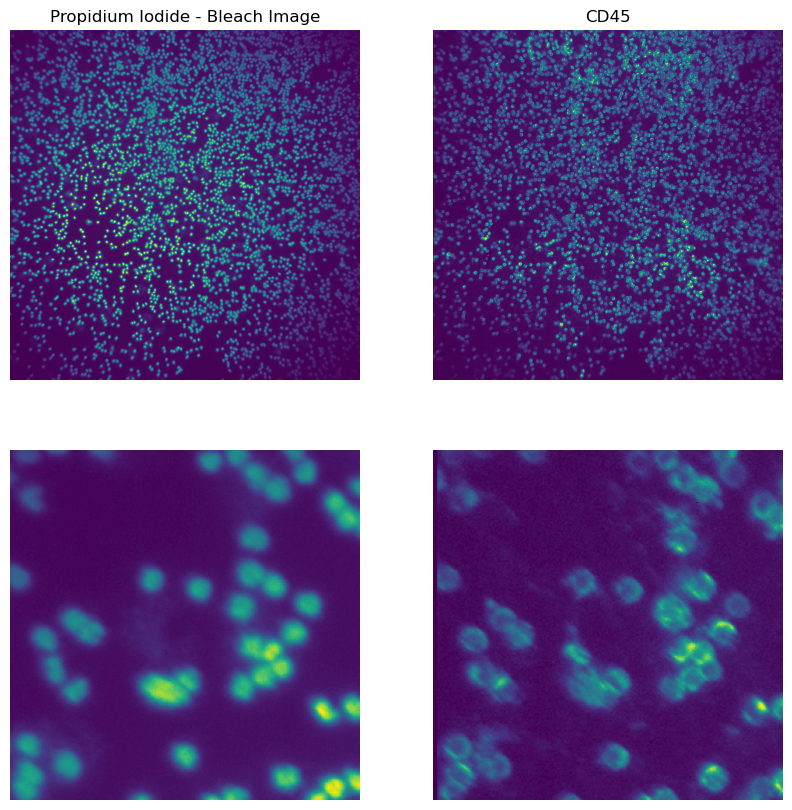

In [7]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].axis('off')
axs[0, 0].imshow(prop_iodide)
axs[0, 0].set_title("Propidium Iodide - Bleach Image")
axs[0, 1].axis('off')
axs[0, 1].imshow(cd45)
axs[0, 1].set_title("CD45")
axs[1, 0].axis('off')
axs[1, 0].imshow(prop_iodide[:250, :250])
axs[1, 1].axis('off')
axs[1, 1].imshow(cd45[:250, :250])
plt.show()

____
3. Segment nucleus and membrane signals and visualize results:

In [8]:
nuclei_labels, nuclei_centers = seg.segment(prop_iodide)
membrane_labels, membrane_centers = seg.segment(cd45)

1/1 [==============================] - 1s 596ms/step


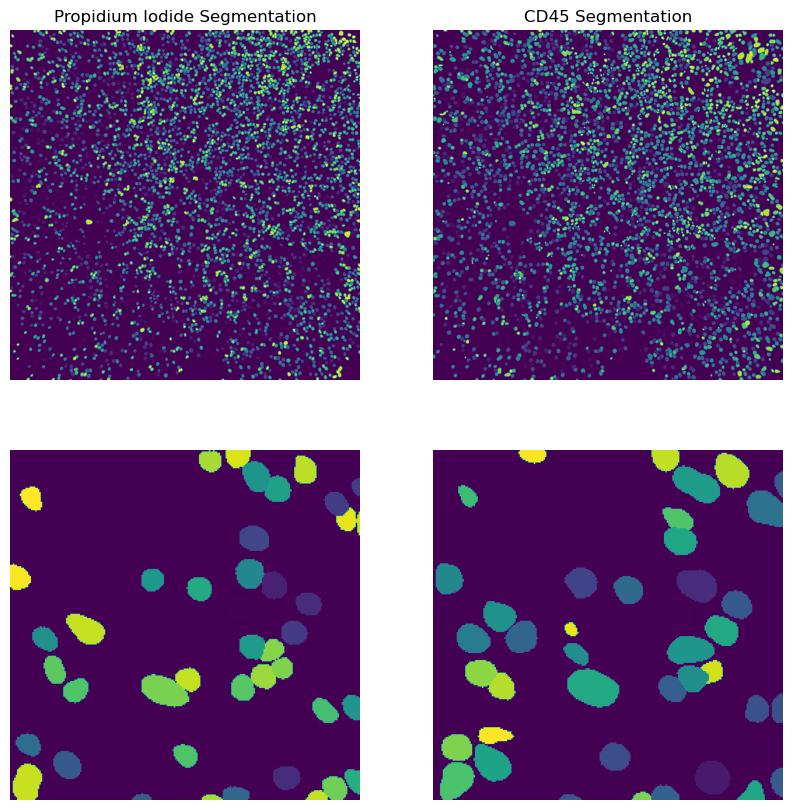

In [9]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].axis('off')
axs[0,0].imshow(nuclei_labels)
axs[0,0].set_title("Propidium Iodide Segmentation")
axs[0,1].axis('off')
axs[0,1].imshow(membrane_labels)
axs[0,1].set_title("CD45 Segmentation")
axs[1,0].axis('off')
axs[1,0].imshow(nuclei_labels[:250, :250])
axs[1,1].axis('off')
axs[1,1].imshow(membrane_labels[:250, :250])
plt.show()

____
4. Reconstruct missing membranes and visualize result:

In [10]:
reconstructed_membranes, nuclei_centers_without_membrane, radii_ratio, nucleus_radii_to_circle = seg.existing_membranes_as_nuclei_NN(membrane_labels, nuclei_labels, nuclei_centers)

100%|████████████████████████████████████████████████████████████████████████████████████████| 3961/3961 [00:45<00:00, 86.22it/s]


In [11]:
estimated_membranes = seg.estimate_membranes_as_nuclei_NN_in_radius(nuclei_labels, nuclei_centers_without_membrane, radii_ratio, nucleus_radii_to_circle)

100%|███████████████████████████████████████████████████████████████████████████████████████| 1652/1652 [00:15<00:00, 104.48it/s]


___
5. Combine all membranes and visualize result:

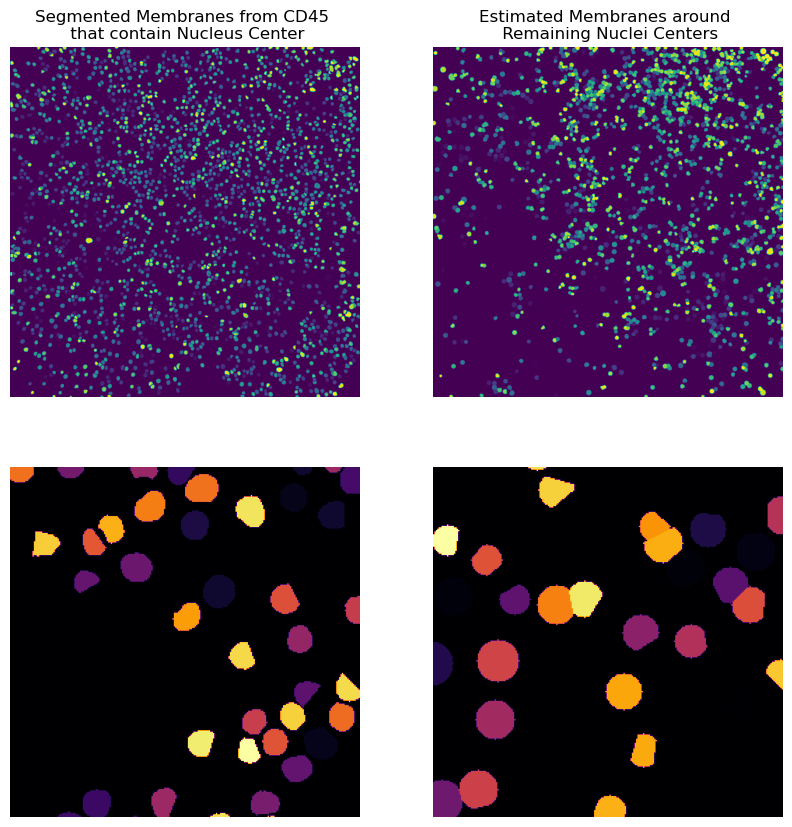

In [12]:
f, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].axis('off')
axs[0,0].imshow(reconstructed_membranes)
axs[0,0].set_title("Segmented Membranes from CD45 \n that contain Nucleus Center")
axs[0,1].axis('off')
axs[0,1].imshow(estimated_membranes)
axs[0,1].set_title("Estimated Membranes around \n Remaining Nuclei Centers")
axs[1,0].axis('off')
axs[1,0].imshow(reconstructed_membranes[1000:1250, 1000:1250], cmap="inferno")
#plt.imsave("rec_zoom.png", reconstructed_membranes1[1000:1250, 1000:1250], cmap="inferno")
axs[1,1].axis('off')
axs[1,1].imshow(estimated_membranes[1000:1250, 1000:1250], cmap="inferno")
#plt.imsave("est_zoom.png", estimated_membranes1[1000:1250, 1000:1250], cmap="inferno")

plt.show()

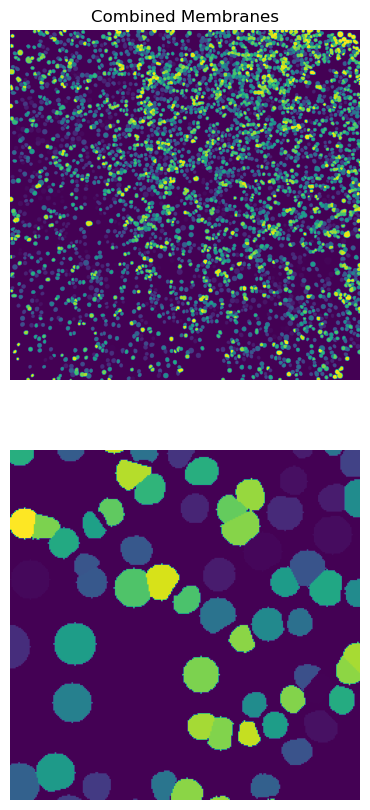

In [13]:
combined_membranes = reconstructed_membranes + estimated_membranes
f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].axis('off')
axs[0].imshow(combined_membranes)
axs[0].set_title("Combined Membranes")

axs[1].imshow(combined_membranes[1000:1250, 1000:1250])
#plt.imsave("comb_zoom.png", combined_membranes[1000:1250, 1000:1250], cmap="inferno")

axs[1].axis('off')
plt.show()

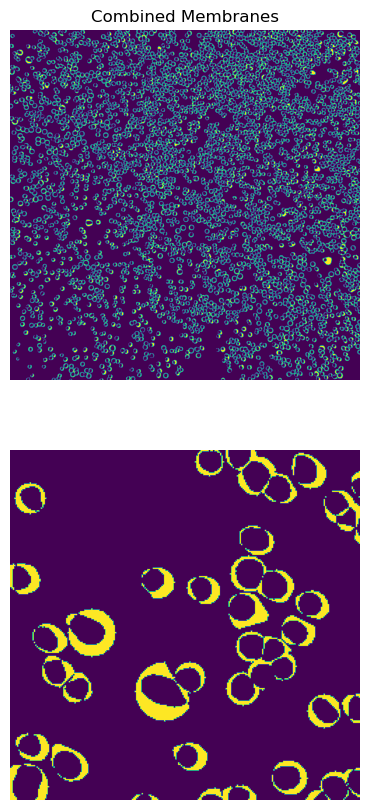

In [14]:
only_membranes = combined_membranes != nuclei_labels
f, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].axis('off')
axs[0].imshow(only_membranes)
axs[0].set_title("Combined Membranes")

axs[1].imshow(only_membranes[:250, :250])
axs[1].axis('off')
plt.show()